# 3D CNN

Basic + Augmentations (Invert)

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')

import datetime
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np

from src.data import train_test_split, MRISequence
from src.model import create_model, compile_model, load_checkpoint
from src.model.training import train
from src.model.evaluation import plot_training_history, show_simple_metrics, show_metrics

In [2]:
import tensorflow as tf

RANDOM_SEED = 69200869
tf.random.set_seed(RANDOM_SEED)

print(tf.version.VERSION)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.1
Num GPUs Available:  1


## Setup

In [3]:
%%time

ROOT_DIR = '../../tmp'
DEFAULT_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'checkpoints')
DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'bckp-checkpoints')

LOG_DIRECTORY = os.path.join(ROOT_DIR, 'logs')
CHECKPOINT_DIRECTORY = DEFAULT_CHECKPOINT_DIRECTORY_LOCAL

LOG_DIRECTORY_LOCAL = LOG_DIRECTORY
CHECKPOINT_DIRECTORY_LOCAL = CHECKPOINT_DIRECTORY

DATA_DIR_NAME = 'data-v3'
DATA_DIR = os.path.join(ROOT_DIR, DATA_DIR_NAME)

saliencies_and_segmentations_v2_path = os.path.join(ROOT_DIR, 'saliencies_and_segmentations_v2')

if not os.path.exists(CHECKPOINT_DIRECTORY):
    os.mkdir(CHECKPOINT_DIRECTORY)

if not os.path.exists(LOG_DIRECTORY):
    os.mkdir(LOG_DIRECTORY)

val = False
    
class_names = ['AD', 'CN']

# get paths to data
train_dir, test_dir, val_dir = train_test_split(
    saliencies_and_segmentations_v2_path, 
    ROOT_DIR, 
    split=(0.8, 0.15, 0.05), 
    dirname=DATA_DIR_NAME)

# set the batch size for mri seq
batch_size = 12
input_shape = (104, 128, 104, 1) # (112, 112, 105, 1)
resize_img = True
crop_img = True

# if y is one-hot encoded or just scalar number
one_hot = True

# class weightss (see analysis notebook)
class_weights = {0: 0.8072289156626505, 1: 1.3137254901960784}

# description statistics of the dataset
desc = {'mean': -3.6344006e-09, 'std': 1.0000092, 'min': -1.4982183, 'max': 10.744175}

if 'desc' not in locals():
    print('initializing desc...')
    desc = get_description(MRISequence(
        train_dir,
        64,
        class_names=class_names,
        input_shape=input_shape),
        max_samples=None)
    print(desc)


normalization={ 'type':'normalization', 'desc': desc }
# normalization={'type':'standardization', 'desc':desc }

augmentations = None
augmentations_inplace = True
# enable augmentations in mri seq (otherwise it can be enabled in dataset)
# augmentations={ 'random_swap_hemispheres': 0.5 }

# initialize sequences
print('initializing train_seq...')
train_seq = MRISequence(
    train_dir,
    batch_size,
    class_names=class_names,
    augmentations=augmentations,
    augmentations_inplace=augmentations_inplace,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    class_weights=class_weights,
    normalization=normalization)

print('initializing test_seq...')
test_seq = MRISequence(
    test_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    normalization=normalization)

if val:
    print('initializing val_seq...')
    val_seq = MRISequence(
        val_dir,
        batch_size,
        class_names=class_names,
        input_shape=input_shape,
        resize_img=resize_img,
        crop_img=crop_img,
        one_hot=one_hot,
        class_weights=class_weights,
        normalization=normalization)
else:
    print('val_seq = test_seq')
    val_seq = test_seq
    
model_key = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join(LOG_DIRECTORY, model_key)
print(f'log_dir: {log_dir}')

not copying files since the destination directory already exists
initializing train_seq...
initializing test_seq...
val_seq = test_seq
log_dir: ../../tmp\logs\20201215-131029
Wall time: 5 ms


In [20]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
# pos / neg
initial_bias = np.log([159/243, 243/159])

model_config = {
    'input_shape': input_shape,
    'class_names': class_names,
#     'l2_beta': 0.001,
#     'l2_beta': 0.0005,
#     'l2_beta': None,
#     'dropout': 0.10,
#     'dropout': None,
    'output_bias': initial_bias,
#     'output_bias': None,
    # https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
    'batch_norm': False,
    'is_complex': False, # a complex layer from the paper, max batch_size is 3
}

compile_config = {
    # default is 0.001
#     'learning_rate': 0.000075,
    'learning_rate': 0.00025,
    'decay_steps': 25,
    'decay_rate': 0.96,
#     'beta_1': 0.85,
    'beta_1': 0.90,
#     'beta_2': 0.990,
    'beta_2': 0.999,
}

train_config = {
    'model_key': model_key,
    'epochs': 200,
    'patience': 25,
    'tensorboard_update_freq': 'epoch',
    'mri_tensorboard_callback': False,
    'model_checkpoint_callback': {'monitor': 'val_auc', 'mode': 'max', 'save_best_only': True},
    'early_stopping_monitor': {'monitor': 'val_auc', 'mode': 'max'},
    'augmentations': {
        'invert': (0.5, None),
        'rotate': (0, 5), # probability, degrees
        'zoom': (0, 0.015),
        'shear': (0.2, 2.5), # probability, degrees
        'blur': (0, 0.8),
        'noise': (0, 0.00025)
    },
    'batch_size': 10,
#     'model_checkpoint_callback': False,
}

## Train

In [5]:
model = create_model(**model_config)
model, *_ = compile_model(model, **compile_config)
model.build(input_shape=input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 104, 128, 104, 32) 896       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 52, 64, 52, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 52, 64, 52, 64)    55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 17, 21, 17, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 17, 21, 17, 128)   221312    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 4, 5, 4, 128)      0         
_________________________________________________________________
flatten (Flatten)            (None, 10240)             0

In [6]:
# load_checkpoint(model, DEFAULT_CHECKPOINT_DIRECTORY_LOCAL, '20201213-182225', 'cp-0002.ckpt')

In [7]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())

['/device:GPU:0']


In [23]:
%%time

model, checkpoint_dir, history = train(
    model,
    train_seq,
    test_seq,
    CHECKPOINT_DIRECTORY,
    LOG_DIRECTORY,
    DATA_DIR,
    **train_config
)

model key: 20201215-131029
checkpoint dir: ../../tmp\checkpoints\20201215-131029
log dir: ../../tmp\logs\20201215-131029
loading ../../tmp\data-v3\train_x.npy, ../../tmp\data-v3\train_y.npy...
loading ../../tmp\data-v3\val_x.npy, ../../tmp\data-v3\val_y.npy...
training...
Epoch 1/200
41/41 [==============================] - ETA: 0s - loss: 0.7283 - recall: 0.4925 - precision: 0.4925 - auc: 0.4695 - categorical_accuracy: 0.4925
Epoch 00001: val_auc improved from -inf to 0.44070, saving model to ../../tmp\checkpoints\20201215-131029\cp-0001.ckpt
41/41 [==============================] - 16s 378ms/step - loss: 0.7283 - recall: 0.4925 - precision: 0.4925 - auc: 0.4695 - categorical_accuracy: 0.4925 - val_loss: 0.7451 - val_recall: 0.3800 - val_precision: 0.3800 - val_auc: 0.4407 - val_categorical_accuracy: 0.3800
Epoch 2/200
41/41 [==============================] - ETA: 0s - loss: 0.7150 - recall: 0.4950 - precision: 0.4950 - auc: 0.4365 - categorical_accuracy: 0.4950
Epoch 00002: val_auc d

Epoch 17/200
41/41 [==============================] - ETA: 0s - loss: 0.6191 - recall: 0.6468 - precision: 0.6468 - auc: 0.7002 - categorical_accuracy: 0.6468
Epoch 00017: val_auc improved from 0.52815 to 0.56340, saving model to ../../tmp\checkpoints\20201215-131029\cp-0017.ckpt
41/41 [==============================] - 14s 337ms/step - loss: 0.6191 - recall: 0.6468 - precision: 0.6468 - auc: 0.7002 - categorical_accuracy: 0.6468 - val_loss: 0.6626 - val_recall: 0.4800 - val_precision: 0.4800 - val_auc: 0.5634 - val_categorical_accuracy: 0.4800
Epoch 18/200
41/41 [==============================] - ETA: 0s - loss: 0.6009 - recall: 0.6542 - precision: 0.6542 - auc: 0.7301 - categorical_accuracy: 0.6542
Epoch 00018: val_auc improved from 0.56340 to 0.56680, saving model to ../../tmp\checkpoints\20201215-131029\cp-0018.ckpt
41/41 [==============================] - 14s 342ms/step - loss: 0.6009 - recall: 0.6542 - precision: 0.6542 - auc: 0.7301 - categorical_accuracy: 0.6542 - val_loss: 0.6

Epoch 33/200
41/41 [==============================] - ETA: 0s - loss: 0.4184 - recall: 0.8184 - precision: 0.8184 - auc: 0.9051 - categorical_accuracy: 0.8184
Epoch 00033: val_auc improved from 0.62995 to 0.64805, saving model to ../../tmp\checkpoints\20201215-131029\cp-0033.ckpt
41/41 [==============================] - 14s 344ms/step - loss: 0.4184 - recall: 0.8184 - precision: 0.8184 - auc: 0.9051 - categorical_accuracy: 0.8184 - val_loss: 0.6831 - val_recall: 0.6100 - val_precision: 0.6100 - val_auc: 0.6480 - val_categorical_accuracy: 0.6100
Epoch 34/200
41/41 [==============================] - ETA: 0s - loss: 0.4099 - recall: 0.7985 - precision: 0.7985 - auc: 0.9058 - categorical_accuracy: 0.7985
Epoch 00034: val_auc improved from 0.64805 to 0.64960, saving model to ../../tmp\checkpoints\20201215-131029\cp-0034.ckpt
41/41 [==============================] - 14s 347ms/step - loss: 0.4099 - recall: 0.7985 - precision: 0.7985 - auc: 0.9058 - categorical_accuracy: 0.7985 - val_loss: 0.6

Epoch 48/200
41/41 [==============================] - ETA: 0s - loss: 0.3028 - recall: 0.8905 - precision: 0.8905 - auc: 0.9618 - categorical_accuracy: 0.8905
Epoch 00048: val_auc improved from 0.75880 to 0.76060, saving model to ../../tmp\checkpoints\20201215-131029\cp-0048.ckpt
41/41 [==============================] - 14s 339ms/step - loss: 0.3028 - recall: 0.8905 - precision: 0.8905 - auc: 0.9618 - categorical_accuracy: 0.8905 - val_loss: 0.6350 - val_recall: 0.7200 - val_precision: 0.7200 - val_auc: 0.7606 - val_categorical_accuracy: 0.7200
Epoch 49/200
41/41 [==============================] - ETA: 0s - loss: 0.2998 - recall: 0.8955 - precision: 0.8955 - auc: 0.9637 - categorical_accuracy: 0.8955
Epoch 00049: val_auc improved from 0.76060 to 0.76260, saving model to ../../tmp\checkpoints\20201215-131029\cp-0049.ckpt
41/41 [==============================] - 14s 340ms/step - loss: 0.2998 - recall: 0.8955 - precision: 0.8955 - auc: 0.9637 - categorical_accuracy: 0.8955 - val_loss: 0.6

41/41 [==============================] - ETA: 0s - loss: 0.2568 - recall: 0.9154 - precision: 0.9154 - auc: 0.9772 - categorical_accuracy: 0.9154
Epoch 00064: val_auc did not improve from 0.77150
41/41 [==============================] - 14s 335ms/step - loss: 0.2568 - recall: 0.9154 - precision: 0.9154 - auc: 0.9772 - categorical_accuracy: 0.9154 - val_loss: 0.6331 - val_recall: 0.7400 - val_precision: 0.7400 - val_auc: 0.7703 - val_categorical_accuracy: 0.7400
Epoch 65/200
41/41 [==============================] - ETA: 0s - loss: 0.2538 - recall: 0.9204 - precision: 0.9204 - auc: 0.9784 - categorical_accuracy: 0.9204
Epoch 00065: val_auc did not improve from 0.77150
41/41 [==============================] - 14s 336ms/step - loss: 0.2538 - recall: 0.9204 - precision: 0.9204 - auc: 0.9784 - categorical_accuracy: 0.9204 - val_loss: 0.6342 - val_recall: 0.7400 - val_precision: 0.7400 - val_auc: 0.7698 - val_categorical_accuracy: 0.7400
Epoch 66/200
41/41 [==============================] - E

Epoch 81/200
41/41 [==============================] - ETA: 0s - loss: 0.2407 - recall: 0.9279 - precision: 0.9279 - auc: 0.9808 - categorical_accuracy: 0.9279
Epoch 00081: val_auc did not improve from 0.77200
41/41 [==============================] - 14s 336ms/step - loss: 0.2407 - recall: 0.9279 - precision: 0.9279 - auc: 0.9808 - categorical_accuracy: 0.9279 - val_loss: 0.6351 - val_recall: 0.7400 - val_precision: 0.7400 - val_auc: 0.7710 - val_categorical_accuracy: 0.7400
Epoch 82/200
41/41 [==============================] - ETA: 0s - loss: 0.2422 - recall: 0.9328 - precision: 0.9328 - auc: 0.9811 - categorical_accuracy: 0.9328
Epoch 00082: val_auc did not improve from 0.77200
41/41 [==============================] - 14s 337ms/step - loss: 0.2422 - recall: 0.9328 - precision: 0.9328 - auc: 0.9811 - categorical_accuracy: 0.9328 - val_loss: 0.6351 - val_recall: 0.7400 - val_precision: 0.7400 - val_auc: 0.7709 - val_categorical_accuracy: 0.7400
Epoch 83/200
41/41 [======================

Epoch 98/200
41/41 [==============================] - ETA: 0s - loss: 0.2354 - recall: 0.9328 - precision: 0.9328 - auc: 0.9820 - categorical_accuracy: 0.9328
Epoch 00098: val_auc did not improve from 0.77290
41/41 [==============================] - 14s 336ms/step - loss: 0.2354 - recall: 0.9328 - precision: 0.9328 - auc: 0.9820 - categorical_accuracy: 0.9328 - val_loss: 0.6360 - val_recall: 0.7400 - val_precision: 0.7400 - val_auc: 0.7726 - val_categorical_accuracy: 0.7400
Epoch 99/200
41/41 [==============================] - ETA: 0s - loss: 0.2341 - recall: 0.9378 - precision: 0.9378 - auc: 0.9830 - categorical_accuracy: 0.9378
Epoch 00099: val_auc did not improve from 0.77290
41/41 [==============================] - 14s 335ms/step - loss: 0.2341 - recall: 0.9378 - precision: 0.9378 - auc: 0.9830 - categorical_accuracy: 0.9378 - val_loss: 0.6358 - val_recall: 0.7400 - val_precision: 0.7400 - val_auc: 0.7728 - val_categorical_accuracy: 0.7400
Epoch 100/200
41/41 [=====================

Epoch 115/200
41/41 [==============================] - ETA: 0s - loss: 0.2307 - recall: 0.9403 - precision: 0.9403 - auc: 0.9834 - categorical_accuracy: 0.9403
Epoch 00115: val_auc did not improve from 0.77375
41/41 [==============================] - 14s 336ms/step - loss: 0.2307 - recall: 0.9403 - precision: 0.9403 - auc: 0.9834 - categorical_accuracy: 0.9403 - val_loss: 0.6361 - val_recall: 0.7400 - val_precision: 0.7400 - val_auc: 0.7730 - val_categorical_accuracy: 0.7400
Epoch 116/200
41/41 [==============================] - ETA: 0s - loss: 0.2329 - recall: 0.9478 - precision: 0.9478 - auc: 0.9829 - categorical_accuracy: 0.9478
Epoch 00116: val_auc did not improve from 0.77375
41/41 [==============================] - 14s 335ms/step - loss: 0.2329 - recall: 0.9478 - precision: 0.9478 - auc: 0.9829 - categorical_accuracy: 0.9478 - val_loss: 0.6361 - val_recall: 0.7400 - val_precision: 0.7400 - val_auc: 0.7734 - val_categorical_accuracy: 0.7400
Epoch 117/200
41/41 [===================

41/41 [==============================] - ETA: 0s - loss: 0.2324 - recall: 0.9378 - precision: 0.9378 - auc: 0.9838 - categorical_accuracy: 0.9378
Epoch 00132: val_auc did not improve from 0.77375
41/41 [==============================] - 14s 340ms/step - loss: 0.2324 - recall: 0.9378 - precision: 0.9378 - auc: 0.9838 - categorical_accuracy: 0.9378 - val_loss: 0.6361 - val_recall: 0.7400 - val_precision: 0.7400 - val_auc: 0.7727 - val_categorical_accuracy: 0.7400
Epoch 133/200
41/41 [==============================] - ETA: 0s - loss: 0.2300 - recall: 0.9428 - precision: 0.9428 - auc: 0.9843 - categorical_accuracy: 0.9428
Epoch 00133: val_auc did not improve from 0.77375
41/41 [==============================] - 14s 340ms/step - loss: 0.2300 - recall: 0.9428 - precision: 0.9428 - auc: 0.9843 - categorical_accuracy: 0.9428 - val_loss: 0.6361 - val_recall: 0.7400 - val_precision: 0.7400 - val_auc: 0.7725 - val_categorical_accuracy: 0.7400
Epoch 134/200
41/41 [==============================] -

## Evaluation

Wall time: 135 ms


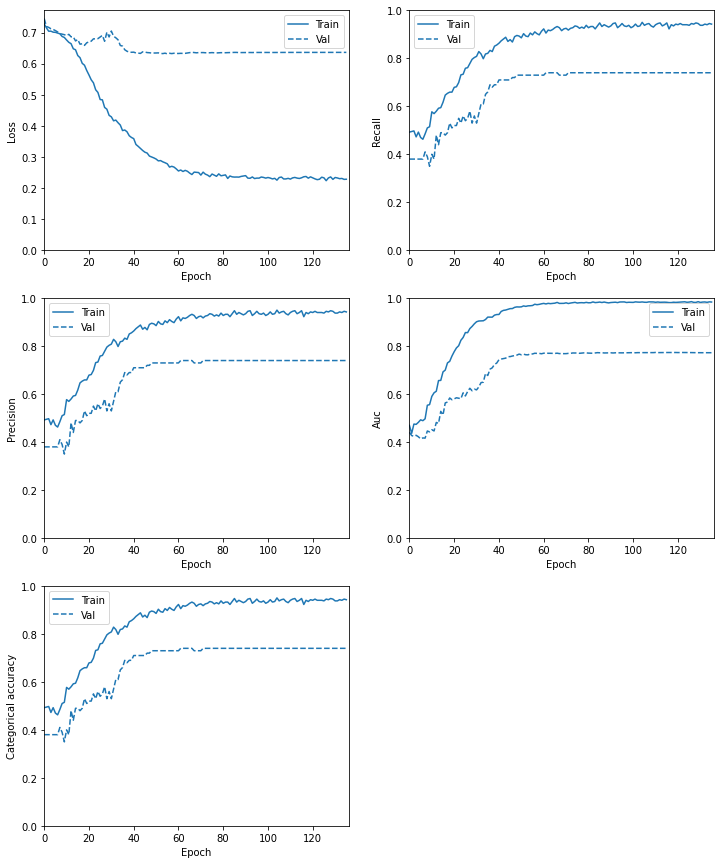

In [24]:
%%time

plot_training_history(history)

In [25]:
%%time

show_simple_metrics(model, test_seq)

loss: 0.6121503114700317
recall: 0.7400000095367432
precision: 0.7400000095367432
auc: 0.7737500071525574
categorical_accuracy: 0.7400000095367432

Wall time: 23.2 s


In binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”. (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
AD
precision: 0.7903225806451613
recall: 0.7903225806451613
f1-score: 0.7903225806451614
support: 62


CN
precision: 0.6578947368421053
recall: 0.6578947368421053
f1-score: 0.6578947368421053
support: 38


micro avg
precision: 0.74
recall: 0.74
f1-score: 0.74
support: 100


macro avg
precision: 0.7241086587436333
recall: 0.7241086587436333
f1-score: 0.7241086587436334
support: 100


weighted avg
precision: 0.74
recall: 0.74
f1-score: 0.74
support: 100


samples avg
precision: 0.74
recall: 0.74
f1-score: 0.74
support: 100


F1
micro: 0.74
macro: 0.7241086587436334


accuracy_score: 0.74
sensitivity_score: 0.7903225806451613
specificity_score: 0.6578947368421053


Wall time: 21.9 s


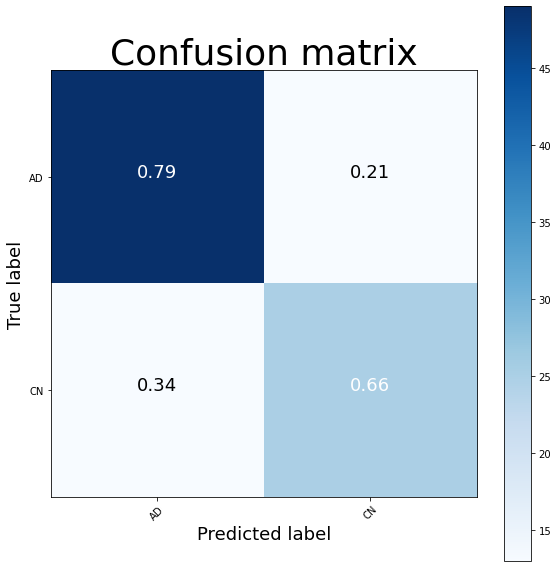

In [26]:
%%time

show_metrics(model, test_seq, class_names)